# CNN Segmentation

In [1]:
%%shell
# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

# extract it in the current folder
unzip PennFudanPed.zip

--2023-04-15 16:43:41--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M   104MB/s    in 0.5s    

2023-04-15 16:43:42 (104 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotatio

In [2]:
import os
import numpy as np
import torch
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
from optparse import OptionParser
from torch import optim
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [3]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # print(img.size)
        newsize = ((128, 128))
        img = img.resize(newsize)
        # print("new: ", img.size)

        mask = Image.open(mask_path)
        # print(img.size)
        newsize = ((128, 128))
        mask = mask.resize(newsize)
        
        mask = np.array(mask)
        mask[mask >= 1] = 255    #Late Submission due to this. In assignment, it given to assign value 1 but with 1 its not working

        if self.transforms is not None:     #Data Augmentation
            img, mask = self.transforms(img, mask)

        return img, mask

    def __len__(self):
        return len(self.imgs)

In [4]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.8.2

# Data Augmentation

In [5]:
class MyCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, tar):
        for t in self.transforms:
            if isinstance(t, transforms.transforms.RandomHorizontalFlip):
              if random.random() > 0.5:
                img = TF.hflip(img)
                tar = TF.hflip(tar)
            elif isinstance(t, transforms.transforms.RandomVerticalFlip):
              if random.random() > 0.5:
                img = TF.vflip(img)
                tar = TF.vflip(tar)
            elif isinstance(t, transforms.transforms.ToTensor):
              img = TF.to_tensor(img)
              tar = TF.to_tensor(tar)
        return img, tar

In [6]:
import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomVerticalFlip(0.5))
    return MyCompose(transforms)

# UNet Architecture

In [7]:
class DoubleConvBlock(nn.Module):
  def __init__(self, in_ch, out_ch):
      super(DoubleConvBlock, self).__init__()
      self.in_ch = in_ch
      self.out_ch = out_ch
      self.conv1 = nn.Sequential(
          nn.Conv2d(self.in_ch, self.out_ch, kernel_size =3, padding = 1),
          nn.BatchNorm2d(out_ch),
          nn.ReLU()
      )
      self.conv2 = nn.Sequential(
          nn.Conv2d(self.out_ch, self.out_ch, kernel_size =3, padding = 1),
          nn.BatchNorm2d(out_ch),
          nn.ReLU()
      )

  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      return x

In [8]:
class DownSample(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DownSample, self).__init__()
        self.down = nn.Sequential(
          nn.MaxPool2d(kernel_size=2, stride=2),
          DoubleConvBlock(in_ch, out_ch)
        )
        
    def forward(self, x):
        x = self.down(x)
        return x

In [9]:
class UpSample(nn.Module):
  def __init__(self, in_ch, out_ch):
      super(UpSample, self).__init__()       
      self.up = nn.Upsample(scale_factor=2, mode='bilinear')
      self.conv = DoubleConvBlock(in_ch, out_ch)

  def forward(self, x1, x2):
      x1 = self.up(x1)
      
      # diffY = x2.size()[2] - x1.size()[2]
      # diffX = x2.size()[3] - x1.size()[3]
      # x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
      #                 diffY // 2, diffY - diffY//2))
      
      x = torch.cat([x2, x1], dim=1)
      x = self.conv(x)
      return x

In [10]:
class SingleConv(nn.Module):
  def __init__(self, in_ch, out_ch):
      super(SingleConv, self).__init__()
      self.conv = nn.Conv2d(in_ch, out_ch, kernel_size = 3, padding = 1)

  def forward(self, x):
      return torch.sigmoid(self.conv(x))

In [11]:
class UNet(nn.Module):
  def __init__(self, n_channels):
      super(UNet, self).__init__()

      #Encoder
      self.initial = DoubleConvBlock(n_channels, 16)
      self.down1 = DownSample(16, 32)
      self.down2 = DownSample(32, 32)

      #Decoder
      self.up1 = UpSample(64, 16)
      self.up2 = UpSample(32, 16)
      self.end = SingleConv(16, 1)

  def forward(self, x):
      x1 = self.initial(x)
      x2 = self.down1(x1)
      x3 = self.down2(x2)

      x = self.up1(x3, x2)
      x = self.up2(x, x1)
      x = self.end(x)
      return x   

# Split Data into train, val and test as 80, 10 and 10

In [12]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

dataset_length = len(dataset)

# define split sizes
train_size = int(0.8 * dataset_length)
val_size = int(0.1 * dataset_length)
test_size = dataset_length - train_size - val_size

# define samplers for each split
indices = list(range(dataset_length))
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:(train_size+val_size)]
test_indices = indices[(train_size+val_size):]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# create data loaders for each split
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset_test, batch_size=8, sampler=val_sampler)
test_loader = DataLoader(dataset_test, batch_size=8, sampler=test_sampler)

In [13]:
class SoftDiceLoss(nn.Module):
    def __init__(self, eps):
        super(SoftDiceLoss, self).__init__()
        self.eps = eps

    def forward(self, outputs, targets):   
        outputs = outputs.view(outputs.size(0), -1).float()
        targets = targets.view(targets.size(0), -1).float()
        intersection = torch.sum(outputs * targets, dim =1)  

        dice = ((2.*intersection + self.eps)/(torch.sum(outputs + targets, dim = 1) + self.eps))
        loss = 1 - dice
        
        return loss.mean()

In [14]:
def DiceScore(outputs, targets, eps = 1):
  outputs = outputs.view(outputs.size(0), -1).float()
  targets = targets.view(targets.size(0), -1).float()
  intersection = torch.sum(outputs * targets, dim =1)  
  dice = ((2.*intersection + eps)/(torch.sum(outputs + targets, dim = 1) + eps))
  return dice.mean().item()

In [15]:
from torchsummary import summary
model = UNet(3)
# summary(model, (3, 128, 128))
model


UNet(
  (initial): DoubleConvBlock(
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (down1): DownSample(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConvBlock(
        (conv1): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (conv2): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Batc

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-3, end_factor=1e-5, total_iters=300)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = SoftDiceLoss(1)
# criterion = SoftDICELoss()
# criterion = nn.BCELoss()
# criterion_dice = SoftDiceLoss(1)
model = model.to(device)
criterion = criterion.to(device)
# criterion_dice = criterion.to(device)

import torchsummary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

54241

In [18]:
import numpy as np

def train_epoch(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    # epoch_dice_loss = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        
        y_pred = model(x)
        optimizer.zero_grad()
        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        return epoch_loss / len(iterator)

In [19]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    # epoch_dice_loss = 0
    epoch_dice_score = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            
            epoch_loss += loss.item()
            
            epoch_dice_score += DiceScore(y_pred, y)
            
        
    return epoch_loss / len(iterator),  epoch_dice_score / len(iterator)

In [20]:
EPOCHS = 350

best_validation_loss = float('inf')
val_dice = []
train_loss_epoch = []
val_loss_epoch = []

for epoch in range(EPOCHS):
  train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
  validation_loss, validation_dice_score = evaluate(model, val_loader, criterion, device)
  val_dice.append(validation_dice_score)
  train_loss_epoch.append(train_loss)
  val_loss_epoch.append(validation_loss)
  # scheduler.step()

  if validation_loss<best_validation_loss:
    torch.save(model, "best_model.pt")
    best_validation_loss=validation_loss 
    
  print (f"Epoch: {epoch+1} \ Training Loss={train_loss:.6f}")
  print (f"Epoch: {epoch+1} \ Validation Loss={validation_loss:.6f}" ) 

Epoch: 1 \ Training Loss=0.045445
Epoch: 1 \ Validation Loss=0.722169
Epoch: 2 \ Training Loss=0.040170
Epoch: 2 \ Validation Loss=0.751290
Epoch: 3 \ Training Loss=0.041301
Epoch: 3 \ Validation Loss=0.770028
Epoch: 4 \ Training Loss=0.044263
Epoch: 4 \ Validation Loss=0.707547
Epoch: 5 \ Training Loss=0.040462
Epoch: 5 \ Validation Loss=0.682091
Epoch: 6 \ Training Loss=0.039891
Epoch: 6 \ Validation Loss=0.730319
Epoch: 7 \ Training Loss=0.039566
Epoch: 7 \ Validation Loss=0.723730
Epoch: 8 \ Training Loss=0.034846
Epoch: 8 \ Validation Loss=0.766135
Epoch: 9 \ Training Loss=0.036314
Epoch: 9 \ Validation Loss=0.762760
Epoch: 10 \ Training Loss=0.042168
Epoch: 10 \ Validation Loss=0.768130
Epoch: 11 \ Training Loss=0.039686
Epoch: 11 \ Validation Loss=0.758401
Epoch: 12 \ Training Loss=0.039586
Epoch: 12 \ Validation Loss=0.767358
Epoch: 13 \ Training Loss=0.037132
Epoch: 13 \ Validation Loss=0.698912
Epoch: 14 \ Training Loss=0.037293
Epoch: 14 \ Validation Loss=0.708754
Epoch: 15 

## We can see that at the end of 200 epoch, val loss decreased continously along with training loss. Hence no overfitting.

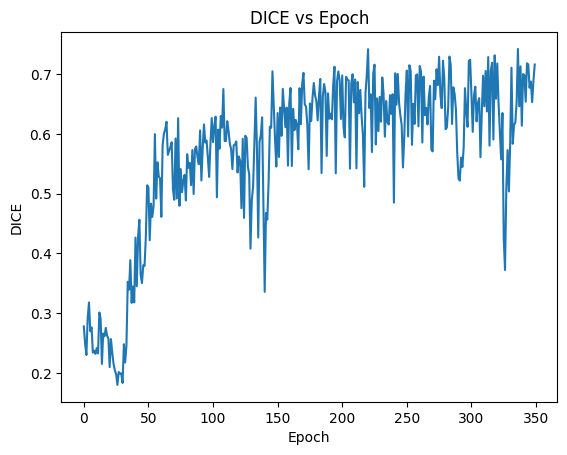

In [21]:
import matplotlib.pyplot as plt
import numpy as np

epoch_x = np.arange(0, 350, 1)
plt.plot(epoch_x, val_dice)
plt.title("DICE vs Epoch")
plt.xlabel('Epoch')
# naming the y axis
plt.ylabel('DICE')
plt.show()


# If we analyze below loss curves, we can see that in between epoch 100 and 150, model was overfitted and similarly around epoch 325. But later we can see that validation loss decreased as training loss dereases.

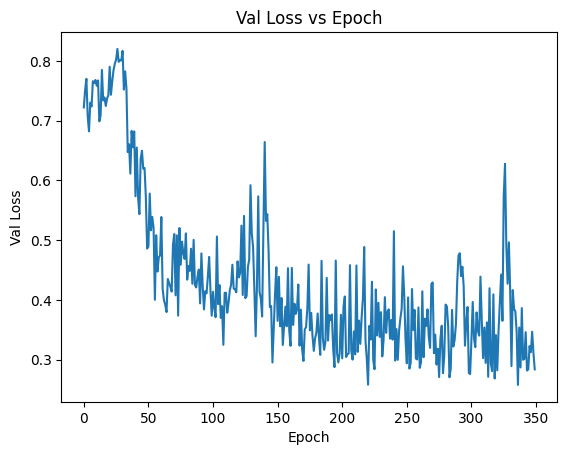

In [22]:
plt.plot(epoch_x, val_loss_epoch)
plt.title("Val Loss vs Epoch")
plt.xlabel('Epoch')
# naming the y axis
plt.ylabel('Val Loss')
plt.show()

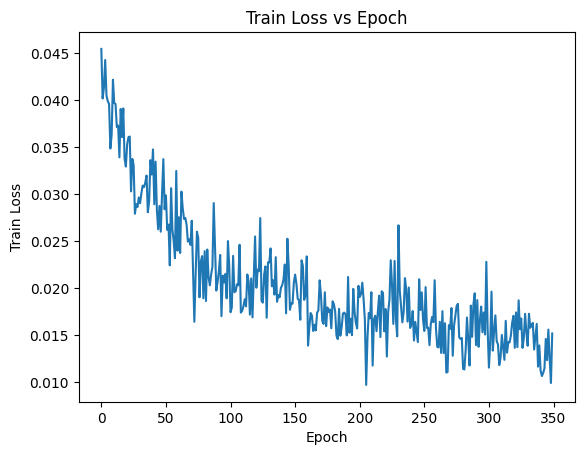

In [23]:
plt.plot(epoch_x, train_loss_epoch)
plt.title("Train Loss vs Epoch")
plt.xlabel('Epoch')
# naming the y axis
plt.ylabel('Train Loss')
plt.show()

# Avg DICE socre of test data => 0.7398249308268229

In [24]:
epoch_dice_score = 0
model = torch.load('best_model.pt')
model.eval()
with torch.no_grad():
  for (x, y) in test_loader:

      x = x.to(device)
      y = y.to(device)

      y_pred = model(x)
      loss = DiceScore(y_pred, y)
      epoch_dice_score += DiceScore(y_pred, y)

print(epoch_dice_score/len(test_loader))


0.7398249308268229


# We can see below that on test data, model was able to output the mask with good accuracy. In one of the test data, network was able to identify both legs and space between both legs and was properly able to segement those area.

## Image, Mask and predicted mask of test data

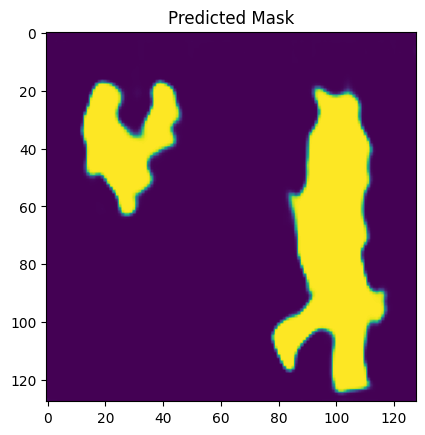

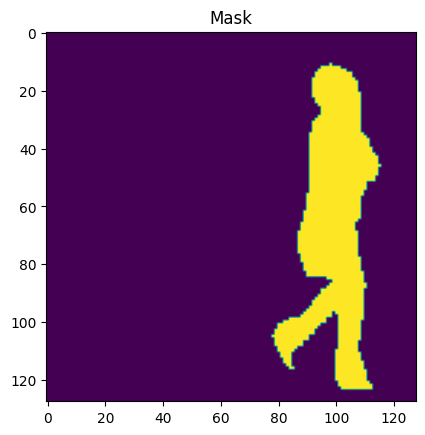

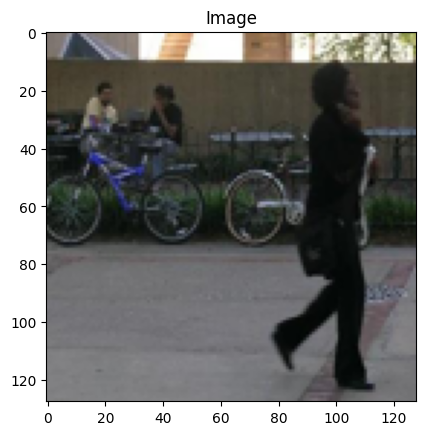

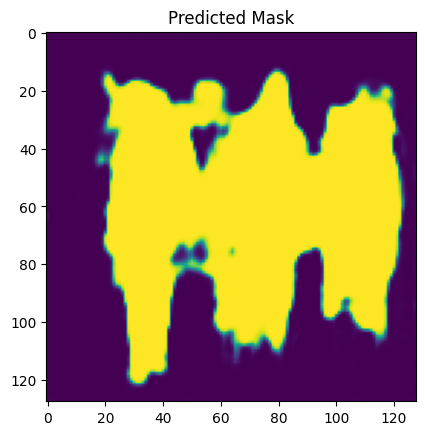

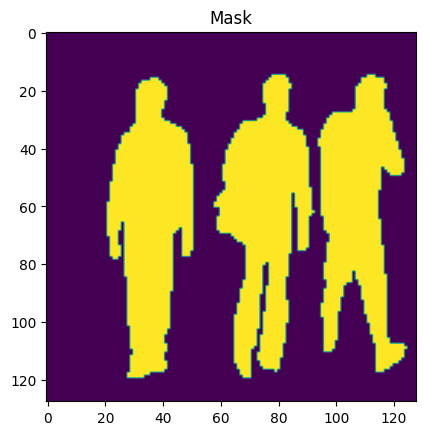

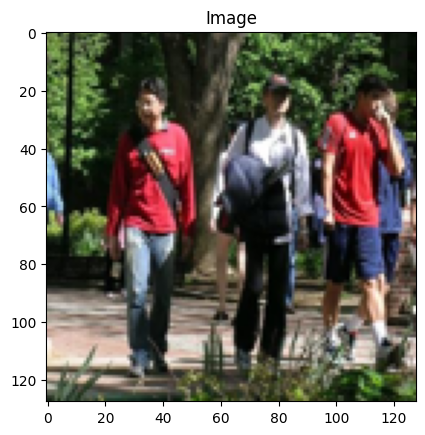

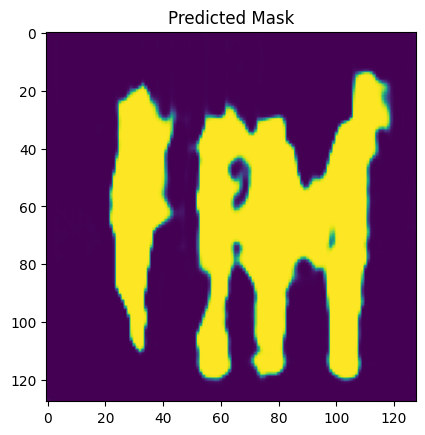

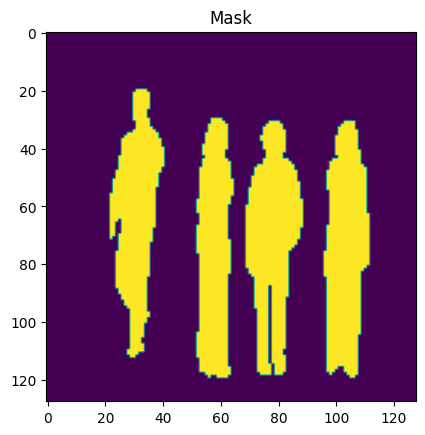

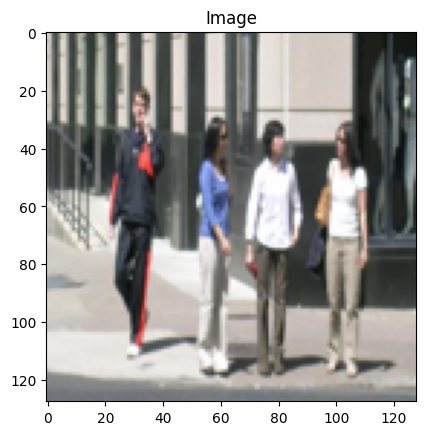

In [31]:
model = torch.load('best_model.pt')
model.eval()
num = 0
with torch.no_grad():
  for (x, y) in test_loader:
    num = num + 1
    x = x.to(device)
    y = y.to(device)

    y_pred = model(x)

    plt.imshow(y_pred[0].permute(1,2,0).detach().numpy())
    plt.title("Predicted Mask")
    plt.show()

    plt.imshow(y[0].permute(1,2,0).detach().numpy())
    plt.title("Mask")
    plt.show()

    plt.imshow(x[0].permute(1,2,0).detach().numpy())
    plt.title("Image")
    plt.show()

    if num == 3:
      break


## Image, Mask and predicted mask of Training data

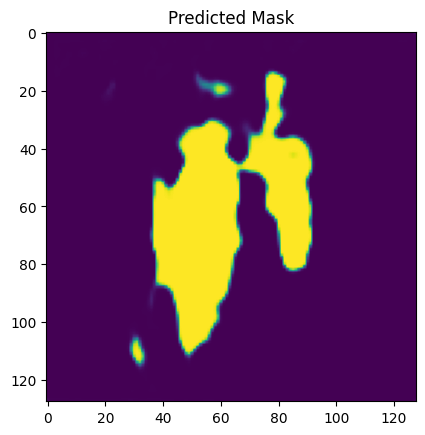

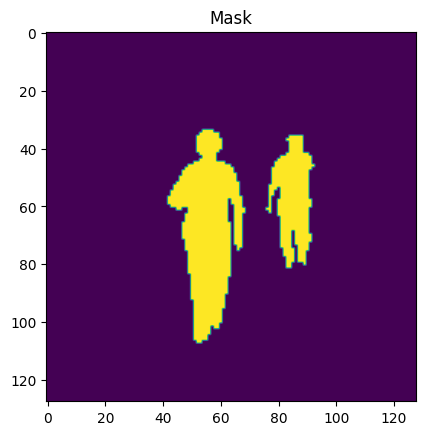

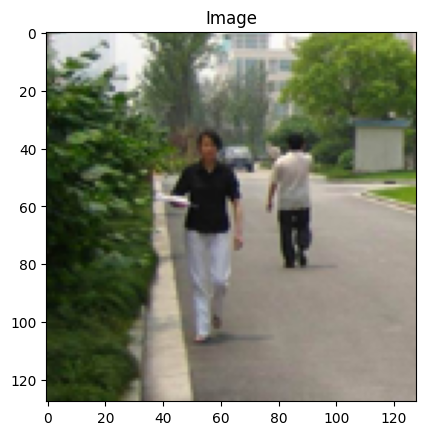

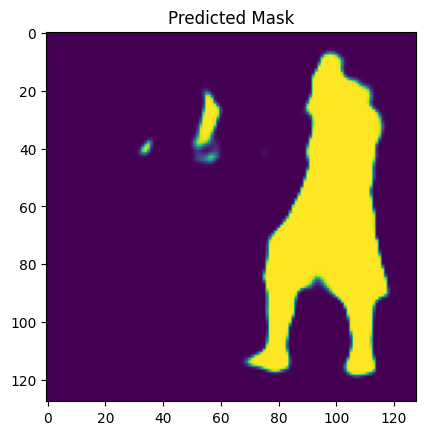

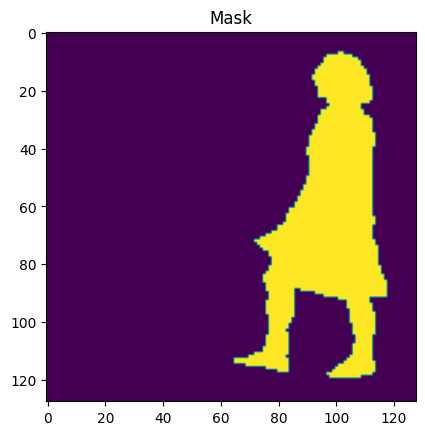

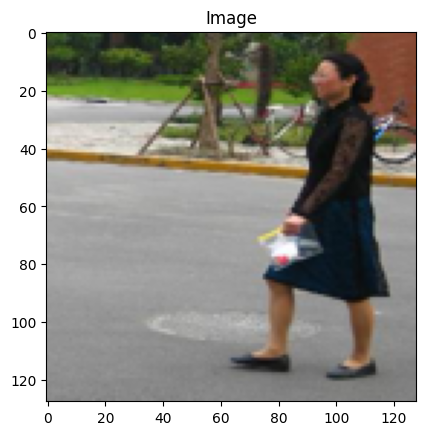

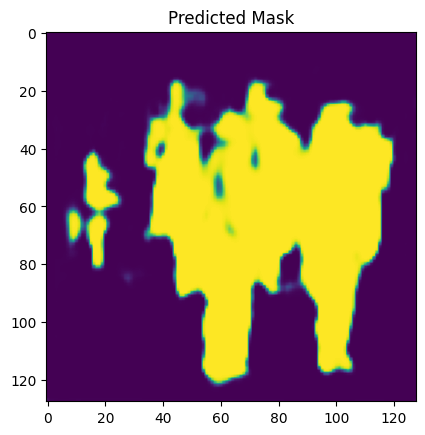

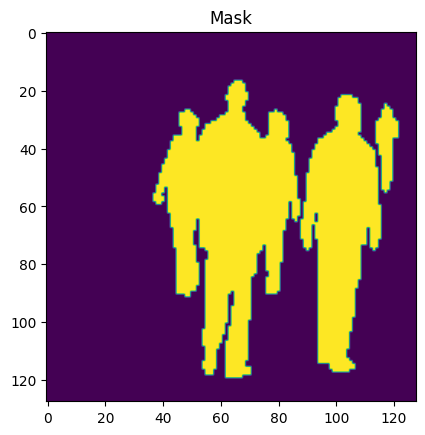

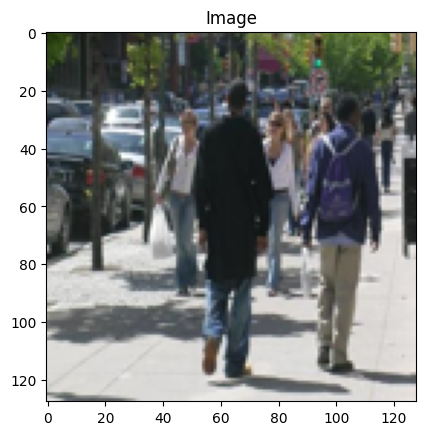

In [32]:
model = torch.load('best_model.pt')
model.eval()
num = 0
with torch.no_grad():
  for (x, y) in train_loader:
    num = num + 1
    x = x.to(device)
    y = y.to(device)

    y_pred = model(x)

    plt.imshow(y_pred[0].permute(1,2,0).detach().numpy())
    plt.title("Predicted Mask")
    plt.show()

    plt.imshow(y[0].permute(1,2,0).detach().numpy())
    plt.title("Mask")
    plt.show()

    plt.imshow(x[0].permute(1,2,0).detach().numpy())
    plt.title("Image")
    plt.show()

    if num == 3:
      break

# Model output on different image other than pennfundan dataset

torch.Size([1, 128, 128])


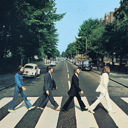

In [28]:
import torchvision.transforms as T

model = torch.load('best_model.pt')

# Test the beatles image
img2 = Image.open('Beatles.jpeg').convert("RGB")
newsize = ((128, 128))
img2 = img2.resize(newsize)
convert_tensor = transforms.ToTensor()
img2 = convert_tensor(img2)
img2 = img2.unsqueeze(0)

# put the model in evaluation mode
model.eval()
with torch.no_grad():
  prediction = model(img2.to(device))

print(prediction.squeeze(0).size())

Image.fromarray(img2.squeeze(0).permute(1, 2, 0).mul(255).byte().numpy())


# We can see below that on different image (other than that of dataset), network was able to identify person although it identified other areas which are not persons but at least all correct persons were segmented. 

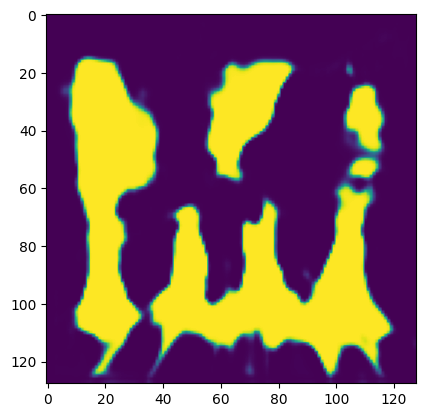

In [29]:
plt.imshow(prediction[0].permute(1,2,0).detach().numpy())
plt.show()

# Example of Data Augmentation

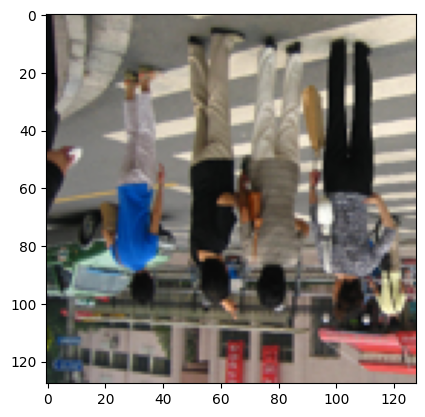

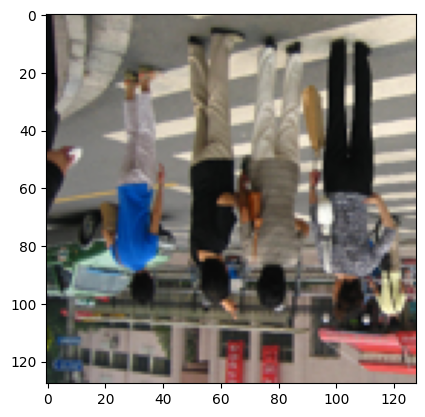

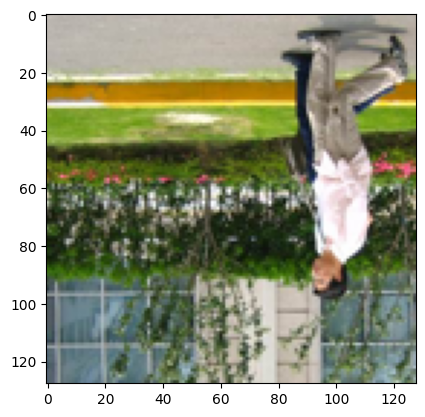

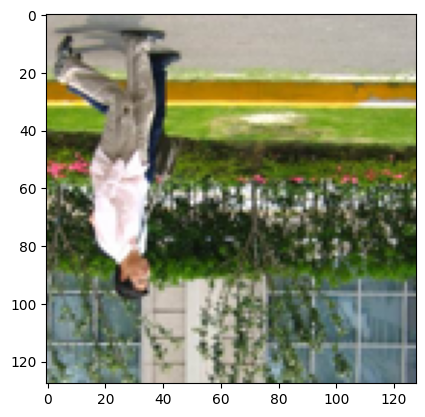

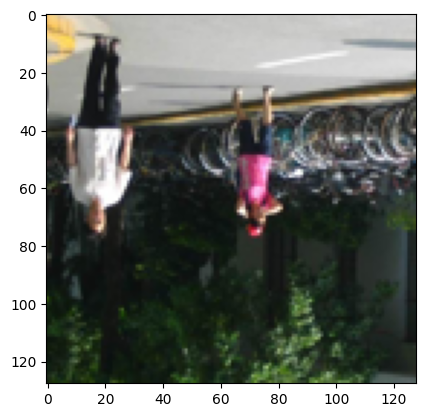

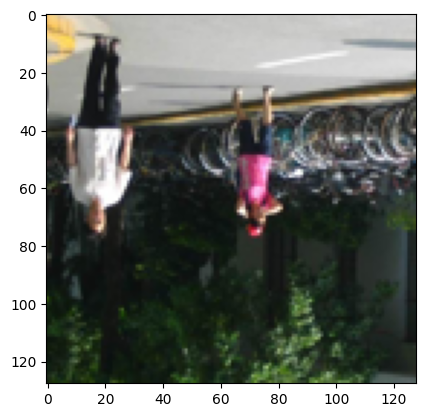

In [30]:
num = 0
for (x, y) in train_loader:
  num = num + 1
  x = x.to(device)
  y = y.to(device)

  plt.imshow(x[0].permute(1,2,0).detach().numpy())
  plt.show()

  convert_tensor = transforms.RandomHorizontalFlip(0.5)
  x = convert_tensor(x)

  plt.imshow(x[0].permute(1,2,0).detach().numpy())
  plt.show()

  if num == 3:
    break